# K-Nearest Neighbors Classifier

In [1]:
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_test = pickle.load( open( "../data/X_test.p", "rb" ) )
X_train = pickle.load( open( "../data/X_train.p", "rb" ) )
y_test = pickle.load( open( "../data/y_test.p", "rb" ) )
y_train = pickle.load( open( "../data/y_train.p", "rb" ) )
#data = pickle.load( open ("../data/encodings_final.p" ) )

Imbalance of the readmission variable

## Normal KNN

73828    0
1751     0
28469    0
84798    0
14545    1
        ..
60399    0
64144    0
28777    0
4583     0
85221    0
Name: readmitted, Length: 18870, dtype: int64 [0 1 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
Confusion Matrix:
[[16461   514]
 [ 1804    91]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     16975
           1       0.15      0.05      0.07      1895

    accuracy                           0.88     18870
   macro avg       0.53      0.51      0.50     18870
weighted avg       0.83      0.88      0.85     18870


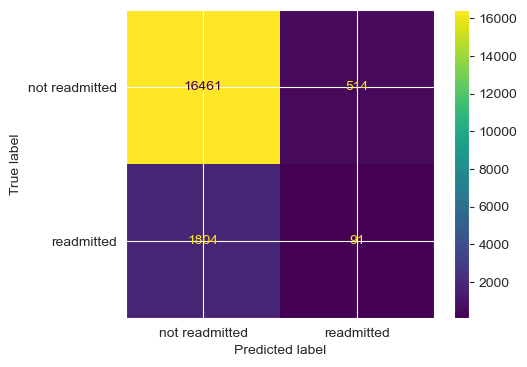

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)

print(y_test, y_pred)
print(y_train.values.ravel())
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

fig,ax = plt.subplots(figsize=(5,4),dpi = 100)
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['not readmitted','readmitted'])
cmp.plot(ax = ax)

## Oversampling with SMOTE

In [3]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train.values.ravel())

print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_oversampled.shape)

Before SMOTE:
readmitted
0    67650
1     8053
Name: count, dtype: int64

After SMOTE:
(135300,)


### k-NN with oversampling

Confusion Matrix:
[[11286  5689]
 [ 1154   741]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.66      0.77     16975
           1       0.12      0.39      0.18      1895

    accuracy                           0.64     18870
   macro avg       0.51      0.53      0.47     18870
weighted avg       0.83      0.64      0.71     18870


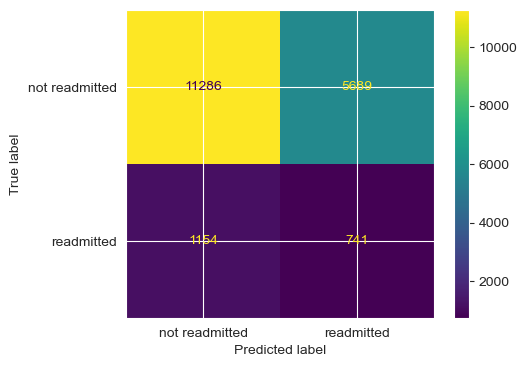

In [4]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_oversampled, y_train_oversampled.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

fig,ax = plt.subplots(figsize=(5,4),dpi = 100)
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['not readmitted','readmitted'])
cmp.plot(ax = ax)

## Undersampling with RandomUnderSampler

In [5]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

print("Before undersampling:")
print(y_train.value_counts())
print("\nAfter undersampling:")
print(y_train_undersampled.value_counts())

Before undersampling:
readmitted
0    67650
1     8053
Name: count, dtype: int64

After undersampling:
readmitted
0    8053
1    8053
Name: count, dtype: int64


### k-NN with undersampling

Confusion Matrix:
[[9872 7103]
 [ 890 1005]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71     16975
           1       0.12      0.53      0.20      1895

    accuracy                           0.58     18870
   macro avg       0.52      0.56      0.46     18870
weighted avg       0.84      0.58      0.66     18870


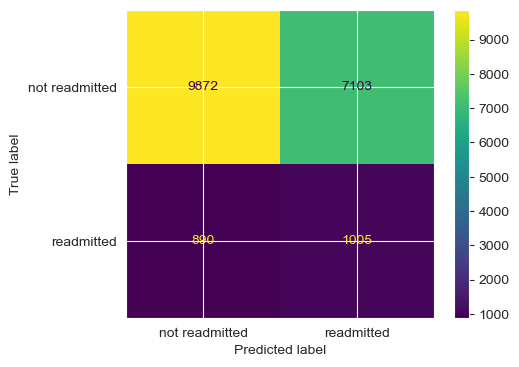

In [6]:
knn = KNeighborsClassifier(n_neighbors=33, metric="manhattan", weights="distance")

knn.fit(X_train_undersampled, y_train_undersampled.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

fig,ax = plt.subplots(figsize=(5,4),dpi = 100)
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['not readmitted','readmitted'])
cmp.plot(ax = ax)

# Hyperparameter tuning

## using GridSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the hyperparameters
hyperparameters = {'n_neighbors': [1000, 5000, 10000], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, hyperparameters, cv=5, n_jobs=-1, scoring='f1')
clf.fit(X_train_undersampled, y_train_undersampled.values.ravel())

print("Best Parameters: ", clf.best_params_)
print("Best cvs score (accuracy): ", clf.best_score_)

Best Parameters:  {'metric': 'euclidean', 'n_neighbors': 5000, 'weights': 'uniform'}
Best cvs score (accuracy):  0.6545105294290892


In [13]:
from sklearn.metrics import make_scorer, recall_score

hyperparameters = {'n_neighbors': [4000, 4070, 5000], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

knn = KNeighborsClassifier()

def recall_optim(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    rec = recall_score(y_true, y_pred) * 0.8
    spe = cm[0,0]/cm[0,:].sum() * 0.2
    if rec < 0.8:
        rec -= 0.2
    return rec + spe

optimize = make_scorer(recall_optim)

clf = GridSearchCV(knn, hyperparameters, cv=5, scoring=optimize, n_jobs=-1)
clf.fit(X_train_undersampled, y_train_undersampled.values.ravel())

print("Best Parameters: ", clf.best_params_)
print("Best cvs score (optimized recall): ", clf.best_score_)

Best Parameters:  {'metric': 'euclidean', 'n_neighbors': 5000, 'weights': 'uniform'}
Best cvs score (optimized recall):  0.5526613075478755


Confusion Matrix:
[[ 2940 14035]
 [  243  1652]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.17      0.29     16975
           1       0.11      0.87      0.19      1895

    accuracy                           0.24     18870
   macro avg       0.51      0.52      0.24     18870
weighted avg       0.84      0.24      0.28     18870


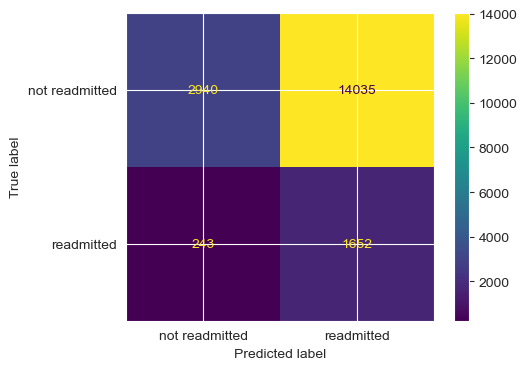

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

knn = KNeighborsClassifier(n_neighbors=5000, metric="euclidean", weights="uniform")

knn.fit(X_train_undersampled, y_train_undersampled.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

fig,ax = plt.subplots(figsize=(5,4),dpi = 100)
cm = confusion_matrix(y_test,y_pred)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['not readmitted','readmitted'])
cmp.plot(ax=ax)